<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session9/Session9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 19), reused 39 (delta 12), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [2]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 6.5MB/s 
     |████████████████████████████████| 38.2MB 74kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import custom_resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *
from vision_pytorch.lrfinder import *

In [ ]:
# import importlib
# importlib.reload(custom_resnet)

<module 'vision_pytorch.models.custom_resnet' from '/content/vision_pytorch/models/custom_resnet.py'>

In [4]:
trainset, testset = download_data()


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


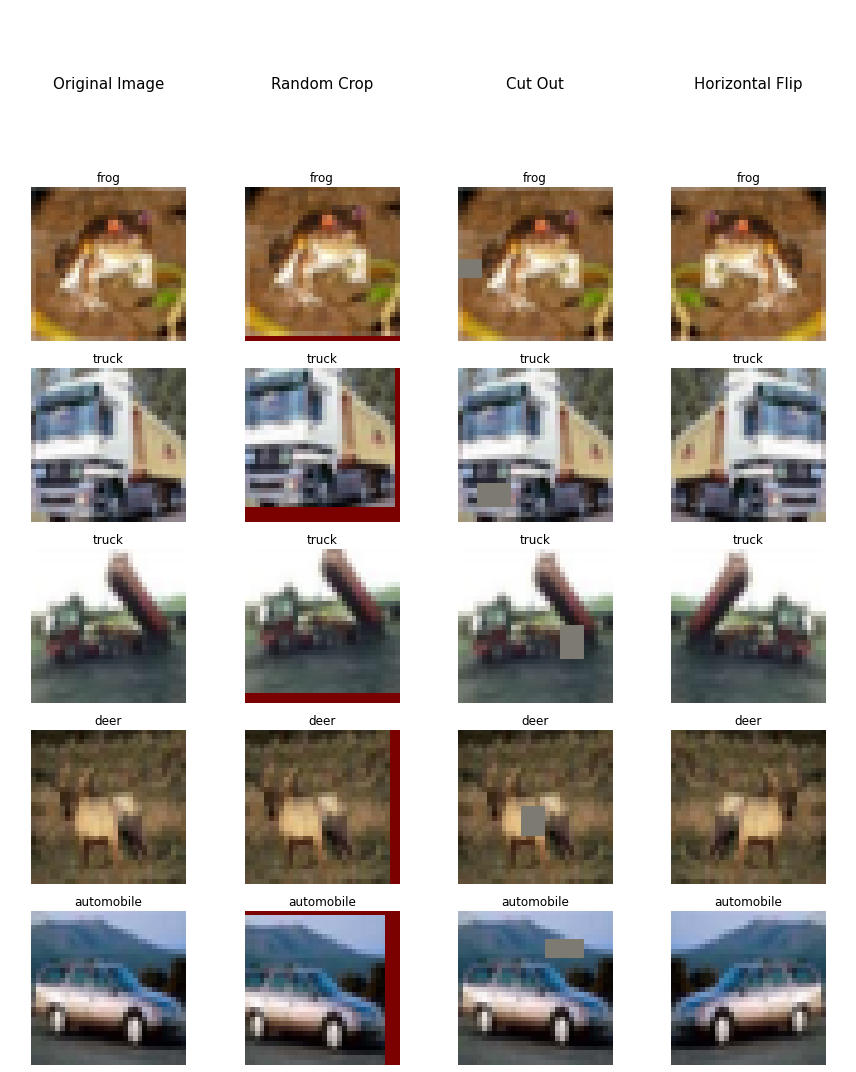

In [5]:
plot_aug({
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False,pad_cval=122.61639 ), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=4, 
                               min_width=4, fill_value=[0.49139968*255, 0.48215841*255, 0.44653091*255], mask_fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
    'Horizontal Flip': A.HorizontalFlip(always_apply=True)
}, data=trainset)

In [6]:
train_transform = A.Compose(
    {      
     A.Sequential([
                   A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by defaulf
                   A.RandomCrop(32,32)
                   ]),
     A.HorizontalFlip(always_apply=False,p=0.1),
     A.CoarseDropout(1, 8, 8, 1, 8, 8,fill_value=0.473363, mask_fill_value=None, always_apply=False,p=0.1),
     A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
     }
     )

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [7]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32
    
print(f'Batch Size: {BATCH_SIZE}')

CUDA Available: True
Batch Size: 512


In [8]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [10]:
net = custom_resnet.customResnet()
net = net.to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
       BasicBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
       BasicBlock-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Learning rate search finished. See the graph with {finder_name}.plot()


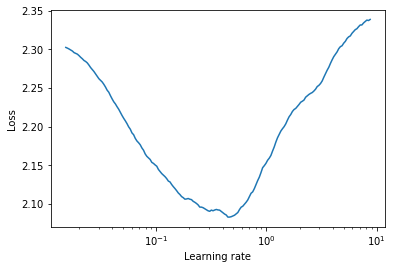

In [11]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()  

In [12]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.44668359215096326


#Train the model

In [13]:
net = custom_resnet.customResnet()
net = net.to(device)

In [14]:

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate/10,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1




Test set: Average loss: 2.1950, Accuracy: 3699/10000 (36.99%)

EPOCH: 2




Test set: Average loss: 2.0313, Accuracy: 5312/10000 (53.12%)

EPOCH: 3




Test set: Average loss: 2.0080, Accuracy: 5535/10000 (55.35%)

EPOCH: 4




Test set: Average loss: 1.9703, Accuracy: 5868/10000 (58.68%)

EPOCH: 5




Test set: Average loss: 1.8481, Accuracy: 7047/10000 (70.47%)

EPOCH: 6




Test set: Average loss: 1.7940, Accuracy: 7561/10000 (75.61%)

EPOCH: 7




Test set: Average loss: 1.8132, Accuracy: 7374/10000 (73.74%)

EPOCH: 8




Test set: Average loss: 1.7755, Accuracy: 7753/10000 (77.53%)

EPOCH: 9




Test set: Average loss: 1.7737, Accuracy: 7769/10000 (77.69%)

EPOCH: 10




Test set: Average loss: 1.7391, Accuracy: 8083/10000 (80.83%)

EPOCH: 11




Test set: Average loss: 1.7389, Accuracy: 8106/10000 (81.06%)

EPOCH: 12




Test set: Average loss: 1.7245, Accuracy: 8227/10000 (82.27%)

EPOCH: 13




Test set: Average loss: 1.7081, Accuracy: 8401/10000 (84.01%)

EPOCH: 14




Test set: Average loss: 1.6908, Accuracy: 8547/10000 (85.47%)

EPOCH: 15




Test set: Average loss: 1.7062, Accuracy: 8400/10000 (84.00%)

EPOCH: 16




Test set: Average loss: 1.7022, Accuracy: 8430/10000 (84.30%)

EPOCH: 17




Test set: Average loss: 1.6890, Accuracy: 8581/10000 (85.81%)

EPOCH: 18




Test set: Average loss: 1.6764, Accuracy: 8676/10000 (86.76%)

EPOCH: 19




Test set: Average loss: 1.6756, Accuracy: 8701/10000 (87.01%)

EPOCH: 20




Test set: Average loss: 1.6729, Accuracy: 8735/10000 (87.35%)

EPOCH: 21




Test set: Average loss: 1.6649, Accuracy: 8803/10000 (88.03%)

EPOCH: 22




Test set: Average loss: 1.6633, Accuracy: 8827/10000 (88.27%)

EPOCH: 23




Test set: Average loss: 1.6593, Accuracy: 8850/10000 (88.50%)

EPOCH: 24




Test set: Average loss: 1.6568, Accuracy: 8866/10000 (88.66%)



Collect the learning rate used for training and plot

In [15]:
print("Range of the LR is {} -> {} -> {}".format(history[4][0], max(history[4]), history[4][-1])) 

Range of the LR is [0.004552480410844074] -> [0.04465414396557571] -> [6.564463589581876e-05]


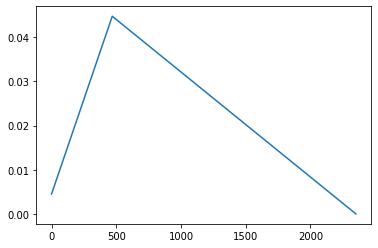

In [16]:
plt.plot(history[4])

#Plots

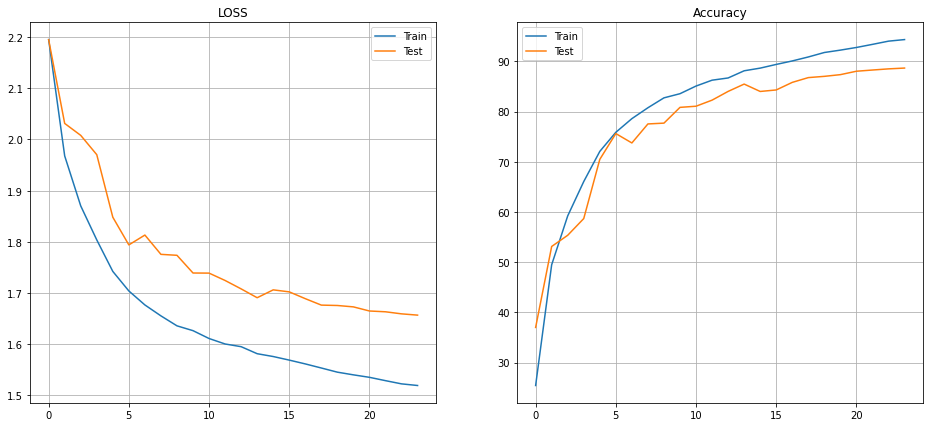

In [17]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[0], label='Train')
axs[1].plot(history[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [18]:
net.eval()
img,lab = test_loader.dataset[100]
img = img.unsqueeze(0).to(device)
pred = net(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


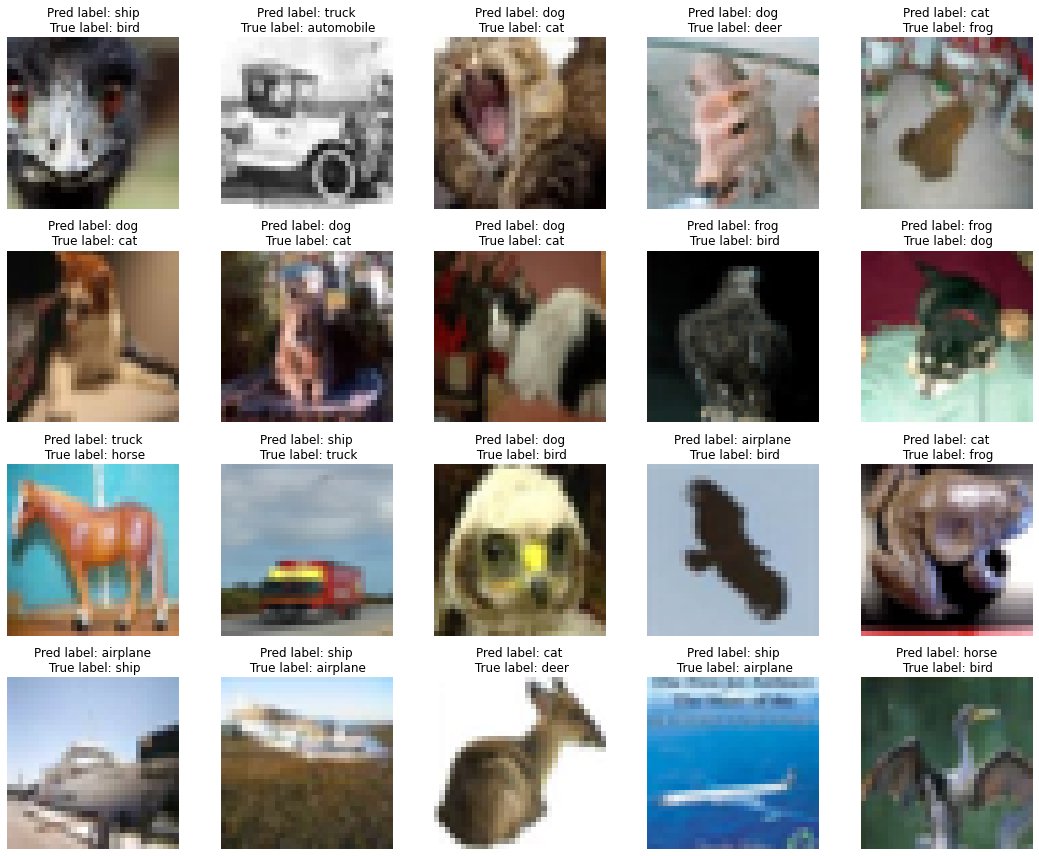

In [19]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
wrong_pred = plot_misclassified(net, test_loader, testset.classes, device, mean, std, return_misclf=True)